<a href="https://colab.research.google.com/github/Rupaljack/THIRD-YEAR-PROJECT/blob/master/HUMAN_ACTIVITY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HUMAN ACTIVITY RECOGNITION





30 participants performed activities of daily living while carrying a waist-mounted smartphone. The phone was configured to record two implemented sensors (accelerometer and gyroscope). For these time series the directors of the underlying study performed feature generation and generated the dataset by moving a fixed-width window of 2.56s over the series. Since the windows had 50% overlap the resulting points are equally spaced (1.28s).

[1 Import Libraries](#1)    
[2 Load Data](#2)    
[3 Dataset Exploration](#3)    
&nbsp;&nbsp;&nbsp;&nbsp;[3.1 Which Features Are There?](#3.1)    
&nbsp;&nbsp;&nbsp;&nbsp;[3.2 What Types Of Data Are There?](#3.2)    
&nbsp;&nbsp;&nbsp;&nbsp;[3.3 How Are The Labels Distributed?](#3.3)    
[4 Activity Exploration](#4)    
&nbsp;&nbsp;&nbsp;&nbsp;[4.1 Are The Activities Separable?](#4.1)    
&nbsp;&nbsp;&nbsp;&nbsp;[4.2 How Good Are The Activities Separable?](#4.2)    
[5 Participant Exploration](#5)    
&nbsp;&nbsp;&nbsp;&nbsp;[5.1 How Good Are the Participants Separable?](#5.1)    
&nbsp;&nbsp;&nbsp;&nbsp;[5.2 How Long Does The Smartphone Gather Data For This Accuracy?](#5.2)    
&nbsp;&nbsp;&nbsp;&nbsp;[5.3 Which Sensor Is More Important For Classifying Participants By Walking Style?](#5.3)    
&nbsp;&nbsp;&nbsp;&nbsp;[5.4 How Long Does The Participant Use The Staircase?](#5.4)    
&nbsp;&nbsp;&nbsp;&nbsp;[5.5 How Much Does The Up-/Downstairs Ratio Vary?](#5.5)    
&nbsp;&nbsp;&nbsp;&nbsp;[5.6 Are There Conspicuities In The Staircase Walking Duration Distribution?](#5.6)    
&nbsp;&nbsp;&nbsp;&nbsp;[5.7 Is There A Unique Walking Style For Each Participant?](#5.7)    
&nbsp;&nbsp;&nbsp;&nbsp;[5.8 How Long Does The Participant Walk?](#5.8)    
&nbsp;&nbsp;&nbsp;&nbsp;[5.9 Is There A Unique Staircase Walking Style For Each Participant?](#5.9)    
[6 Exploring Personal Information](#6)    
&nbsp;&nbsp;&nbsp;&nbsp;[6.1 What Is The Walking Frequency Of A Single Participant?](#6.1)    
&nbsp;&nbsp;&nbsp;&nbsp;[6.2 What Is The Walking Frequency Of Both Found Speeds?](#6.2)    
&nbsp;&nbsp;&nbsp;&nbsp;[6.3 What Are The Frequencies In A Self-Experiment?](#6.3)    
[7 Conclusion](#7)    

## <a id=1>Import Libraries</a>

In [4]:
# To store data
import pandas as pd

# To do linear algebra
import numpy as np
from numpy import pi

# To create plots
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt

# To create nicer plots
import seaborn as sns

# To create interactive plots
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# To get new datatypes and functions
from collections import Counter
from cycler import cycler

# To investigate distributions
from scipy.stats import norm, skew, probplot
from scipy.optimize import curve_fit

# To build models
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# To gbm light
from lightgbm import LGBMClassifier

# To measure time
from time import time

## <a id=2>Load Data</a>

In [5]:
# Load datasets
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

# Combine boths dataframes
train_df['Data'] = 'Train'
test_df['Data'] = 'Test'
both_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
both_df['subject'] = '#' + both_df['subject'].astype(str)

# Create label
label = both_df.pop('Activity')

print('Shape Train:\t{}'.format(train_df.shape))
print('Shape Test:\t{}\n'.format(test_df.shape))

train_df.head()

Shape Train:	(7352, 564)
Shape Test:	(2947, 564)



,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,Data
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,-0.567378,-0.744413,0.852947,0.685845,0.814263,-0.965523,-0.999945,-0.999863,-0.994612,-0.994231,-0.987614,-0.943220,-0.407747,-0.679338,-0.602122,0.929294,-0.853011,0.359910,-0.058526,0.256892,-0.224848,0.264106,-0.095246,0.278851,-0.465085,0.491936,-0.190884,0.376314,0.435129,0.660790,...,-0.936508,0.346989,-0.516080,-0.802760,-0.980135,-0.961309,-0.973653,-0.952264,-0.989498,-0.980135,-0.999240,-0.992656,-0.701291,-1.000000,-0.128989,0.586156,0.374605,-0.991990,-0.990697,-0.989941,-0.992448,-0.991048,-0.991990,-0.999937,-0.990458,-0.871306,-1.000000,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING,Train
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,-0.557851,-0.818409,0.849308,0.685845,0.822637,-0.981930,-0.999991,-0.999788,-0.998405,-0.999150,-0.977866,-0.948225,-0.714892,-0.500930,-0.570979,0.611627,-0.329549,0.284213,0.284595,0.115705,-0.090963,0.294310,-0.281211,0.085988,-0.022153,-0.016657,-0.220643,-0.013429,-0.072692,0.579382,...,-0.841270,0.532061,-0.624871,-0.900160,-0.988296,-0.983322,-0.982659,-0.986321,-0.991829,-0.988296,-0.999811,-0.993979,-0.720683,-0.948718,-0.271958,-0.336310,-0.720015,-0.995854,-0.996399,-0.995442,-0.996866,-0.994440,-0.995854,-0.999981,-0.994544,-1.000000,-1.000000,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING,Train
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,-0.557851,-0.818409,0.843609,0.682401,0.839344,-0.983478,-0.999969,-0.999660,-0.999470,-0.997130,-0.964810,-0.974675,-0.592235,-0.485821,-0.570979,0.273025,-0.086309,0.337202,-0.164739,0.017150,-0.074507,0.342256,-0.332564,0.239281,-0.136204,0.173863,-0.299493,-0.124698,-0.181105,0.608900,...,-0.904762,0.660795,-0.724697,-0.928539,-0.989255,-0.986028,-0.984274,-0.990979,-0.995703,-0.989255,-0.999854,-0.993238,-0.736521,-0.794872,-0.212728,-0.535352,

The directors of the study created an incredible number of features from the two sensors.

## <a id=3>Dataset Exploration</a>
### <a id=3.1>Which Features Are There?</a>

The features seem to have a main name and some information on how they have been computed attached. Grouping the main names will reduce the dimensions for the first impression.

In [6]:
# Group and count main names of columns
pd.DataFrame.from_dict(Counter([col.split('-')[0].split('(')[0] for col in both_df.columns]), orient='index').rename(columns={0:'count'}).sort_values('count', ascending=False)

,count
fBodyAcc,79
fBodyGyro,79
fBodyAccJerk,79
tGravityAcc,40
tBodyAcc,40
tBodyGyroJerk,40
tBodyGyro,40
tBodyAccJerk,40
tBodyAccMag,13
tGravityAccMag,13


Mainly there are 'acceleration' and 'gyroscope' features. A few 'gravity' features are there as well.

Impressive how many features there are in regard of the limited number of sensors used.

### <a id=3.2>What Types Of Data Are There?</a>

In [7]:
# Get null values and dataframe information
print('Null Values In DataFrame: {}\n'.format(both_df.isna().sum().sum()))
both_df.info()

Null Values In DataFrame: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10299 entries, 0 to 10298
Columns: 563 entries, tBodyAcc-mean()-X to Data
dtypes: float64(561), object(2)
memory usage: 44.2+ MB


Except from the label and the newly created 'Data' and 'subject' features there is only numerical data. Fortunately there are no missing values.




## <a id=4>Activity Exploration</a>
### <a id=4.1>Are The Activities Separable?</a>

The dataset is geared towards classifying the activity of the participant. Let us investigate the separability of the classes.

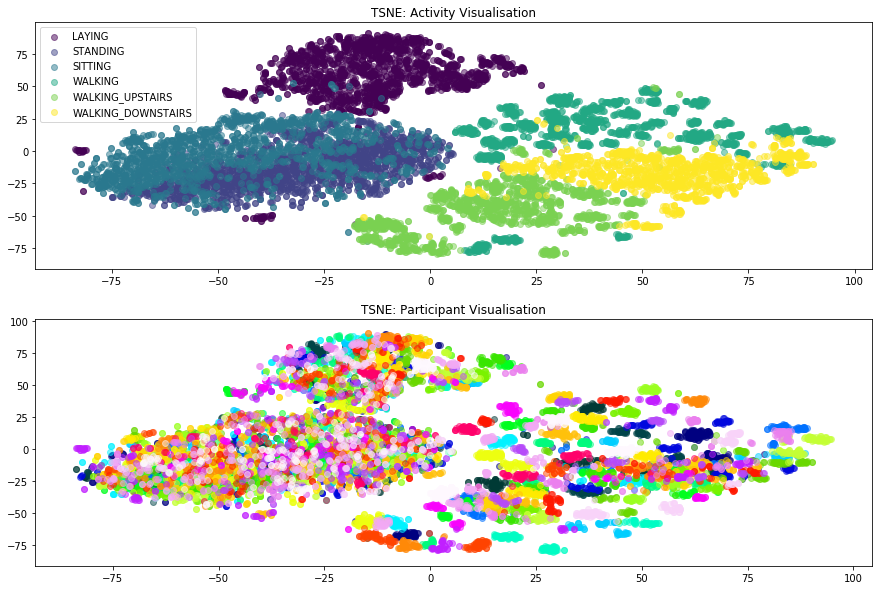

In [9]:
# Create datasets
tsne_data = both_df.copy()
data_data = tsne_data.pop('Data')
subject_data = tsne_data.pop('subject')

# Scale data
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

# Reduce dimensions (speed up)
pca = PCA(n_components=0.9, random_state=3)
tsne_data = pca.fit_transform(tsne_data)

# Transform data
tsne = TSNE(random_state=3)
tsne_transformed = tsne.fit_transform(tsne_data)


# Create subplots
fig, axarr = plt.subplots(2, 1, figsize=(15,10))

### Plot Activities
# Get colors
n = label.unique().shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot each activity
for i, group in enumerate(label_counts.index):
    # Mask to separate sets
    mask = (label==group).values
    axarr[0].scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)
axarr[0].set_title('TSNE: Activity Visualisation')
axarr[0].legend()


### Plot Subjects
# Get colors
n = subject_data.unique().shape[0]
colormap = get_cmap('gist_ncar')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot each participant
for i, group in enumerate(subject_data.unique()):
    # Mask to separate sets
    mask = (subject_data==group).values
    axarr[1].scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)

axarr[1].set_title('TSNE: Participant Visualisation')
plt.show()

In plot 1 you can clearly see the **activities are mostly separable.**

Plot 2 reveals **personal information** of the participants. Everybody has for example an **unique/sparable walking style** (on the upper right). Therefore the smartphone should be able to **detect what you are doing and also who is using the smartphone** (if you are moving around with it).

### <a id=4.2>How Good Are The Activities Separable?</a>

Without much preprocessing and parameter tuning a simple LGBMClassifier should work decently.

In [10]:
# Split training testing data
enc = LabelEncoder()
label_encoded = enc.fit_transform(label)
X_train, X_test, y_train, y_test = train_test_split(tsne_data, label_encoded, random_state=3)

# Create the model
lgbm = LGBMClassifier(n_estimators=500, random_state=3)
lgbm = lgbm.fit(X_train, y_train)

# Test the model
score = accuracy_score(y_true=y_test, y_pred=lgbm.predict(X_test))
print('Accuracy on testset:\t{:.4f}\n'.format(score))

Accuracy on testset:	0.9553



With a basic untuned model the **activity of the smartphone user** can be predicted with an **accuracy of 95%.**<br>
This is pretty striking regarding six equally distributed labels.

**Summary:**<br>
If the smartphone or an App wants to know what you are doing, this is feasible.

## <a id=5>Participant Exploration</a>
### <a id=5.1>How Good Are the Participants Separable?</a>

As we have seen in the second t-SNE plot the separability of the participants seem to vary regarding their activity. Let us investigate this a little bit by fitting the same basic model to the data of each activity separately.

In [11]:
# Store the data
data = []
# Iterate over each activity
for activity in label_counts.index:
    # Create dataset
    act_data = both_df[label==activity].copy()
    act_data_data = act_data.pop('Data')
    act_subject_data = act_data.pop('subject')
    
    # Scale data
    scl = StandardScaler()
    act_data = scl.fit_transform(act_data)

    # Reduce dimensions
    pca = PCA(n_components=0.9, random_state=3)
    act_data = pca.fit_transform(act_data)

    
    # Split training testing data
    enc = LabelEncoder()
    label_encoded = enc.fit_transform(act_subject_data)
    X_train, X_test, y_train, y_test = train_test_split(act_data, label_encoded, random_state=3)


    # Fit basic model
    print('Activity: {}'.format(activity))
    lgbm = LGBMClassifier(n_estimators=500, random_state=3)
    lgbm = lgbm.fit(X_train, y_train)
    
    score = accuracy_score(y_true=y_test, y_pred=lgbm.predict(X_test))
    print('Accuracy on testset:\t{:.4f}\n'.format(score))
    data.append([activity, score])

Activity: LAYING
Accuracy on testset:	0.6481

Activity: STANDING
Accuracy on testset:	0.5493

Activity: SITTING
Accuracy on testset:	0.5303

Activity: WALKING
Accuracy on testset:	0.9513

Activity: WALKING_UPSTAIRS
Accuracy on testset:	0.9249

Activity: WALKING_DOWNSTAIRS
Accuracy on testset:	0.9091



**Detecting the correct participant** regarind their current activity is not alone possible but **astonishing accurate** regarding the 30 different persons **(94% by walking style)**.<br>
Noticable is that the accuracy seems to rise if the participant moves around. This implies a unique walking/movement style for each person.

### <a id=5.2>How Long Does The Smartphone Gather Data For This Accuracy?</a>

The description of the data states; "fixed-width sliding windows of 2.56 sec and 50% overlap" for each datapoint.<br>
Therefore a single datapoint is gathered every 1.28 sec.

In [12]:
# Create duration datafrae
duration_df = (both_df.groupby([label, subject_data])['Data'].count().reset_index().groupby('Activity').agg({'Data':'mean'}) * 1.28).rename(columns={'Data':'Seconds'})
activity_df = pd.DataFrame(data, columns=['Activity', 'Accuracy']).set_index('Activity')
activity_df.join(duration_df)

,Accuracy,Seconds
Activity,,
LAYING,0.648148,82.944000
STANDING,0.549266,81.322667
SITTING,0.530337,75.818667
WALKING,0.951276,73.472000
WALKING_UPSTAIRS,0.924870,65.877333
WALKING_DOWNSTAIRS,0.909091,59.989333


The smartphone is **quite fast (1 - 1.5 min)** in guessing correctly.

### <a id=5.3>Which Sensor Is More Important For Classifying Participants By Walking Style?</a>

I will fit another basic model to the walking data and investigate the feature importances afterwards. Since there are so many features I am going to group them by their sensor (accelerometer = Acc, gyroscope = Gyro)

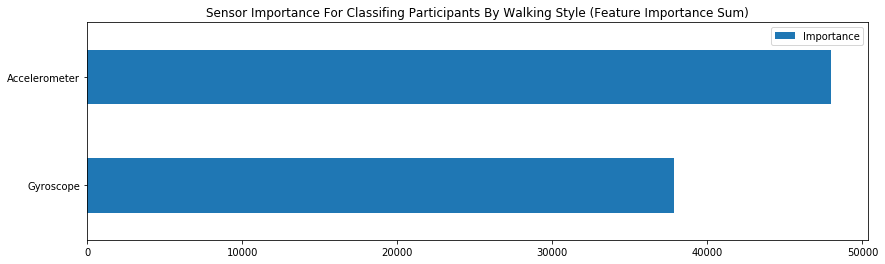

In [13]:
# Create dataset
tsne_data = both_df[label=='WALKING'].copy()
data_data = tsne_data.pop('Data')
subject_data = tsne_data.pop('subject')

# Scale data
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

# Split training testing data
enc = LabelEncoder()
label_encoded = enc.fit_transform(subject_data)
X_train, X_test, y_train, y_test = train_test_split(tsne_data, label_encoded, random_state=3)


# Create model
lgbm = LGBMClassifier(n_estimators=500, random_state=3)
lgbm = lgbm.fit(X_train, y_train)

# Get importances
features = both_df.drop(['Data', 'subject'], axis=1).columns
importances = lgbm.feature_importances_

# Sum importances
data = {'Gyroscope':0, 'Accelerometer':0}
for importance, feature in zip(importances, features):
    if 'Gyro' in feature:
        data['Gyroscope'] += importance
    if 'Acc' in feature:
        data['Accelerometer'] += importance
        
# Create dataframe and plot
sensor_df = pd.DataFrame.from_dict(data, orient='index').rename(columns={0:'Importance'})
sensor_df.plot(kind='barh', figsize=(14,4), title='Sensor Importance For Classifing Participants By Walking Style (Feature Importance Sum)')
plt.show()

The accelerometer supplies slightly more information. Both sensors are important for classification and refraining from using both sensors will be a drawback for the quality of the model.

### <a id=5.4>How Long Does The Participant Use The Staircase?</a>

Since the dataset has been created in an scientific environment nearly equal preconditions for the participants can be assumed. It is highly likely for the participants to have been walking up and down the same number of staircases. Let us investigate their activity durations.

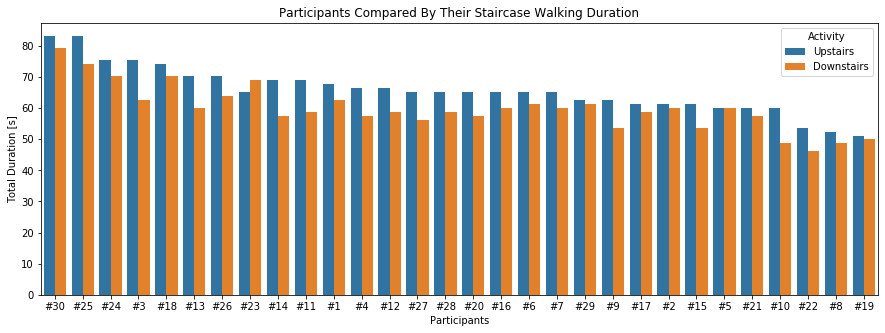

In [14]:
# Group the data by participant and compute total duration of staircase walking
mask = label.isin(['WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'])
duration_df = (both_df[mask].groupby([label[mask], 'subject'])['Data'].count() * 1.28)

# Create plot
plot_data = duration_df.reset_index().sort_values('Data', ascending=False)
plot_data['Activity'] = plot_data['Activity'].map({'WALKING_UPSTAIRS':'Upstairs', 'WALKING_DOWNSTAIRS':'Downstairs'})

plt.figure(figsize=(15,5))
sns.barplot(data=plot_data, x='subject', y='Data', hue='Activity')
plt.title('Participants Compared By Their Staircase Walking Duration')
plt.xlabel('Participants')
plt.ylabel('Total Duration [s]')
plt.show()

Nearly all participants have more data for walking upstairs than downstairs. Assuming an equal number of up- and down-walks the **participants need longer walking upstairs.**<br>
Furthermore the range of the duration is narrow and adjusted to the conditions. A young person being ~50% fast in walking upstairs than an older one is reasonable.

### <a id=5.5>How Much Does The Up-/Downstairs Ratio Vary?</a>

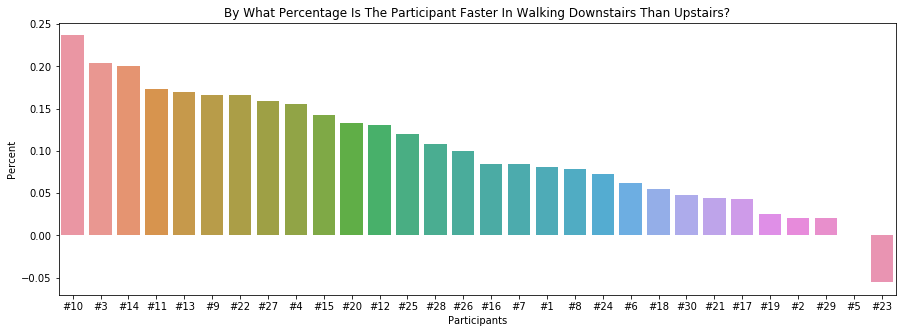

In [15]:
# Create data and plot
plt.figure(figsize=(15,5))
plot_data = ((duration_df.loc['WALKING_UPSTAIRS'] / duration_df.loc['WALKING_DOWNSTAIRS']) -1).sort_values(ascending=False)
sns.barplot(x=plot_data.index, y=plot_data)
plt.title('By What Percentage Is The Participant Faster In Walking Downstairs Than Upstairs?')
plt.xlabel('Participants')
plt.ylabel('Percent')
plt.show()

There is a wide range in between the participants for their **ratio of up-/down-walking.** Since this represents their physical condition I can imagine a **correlation to their age and health** (speculative).

### <a id=5.6>Are There Conspicuities In The Staircase Walking Duration Distribution?</a>

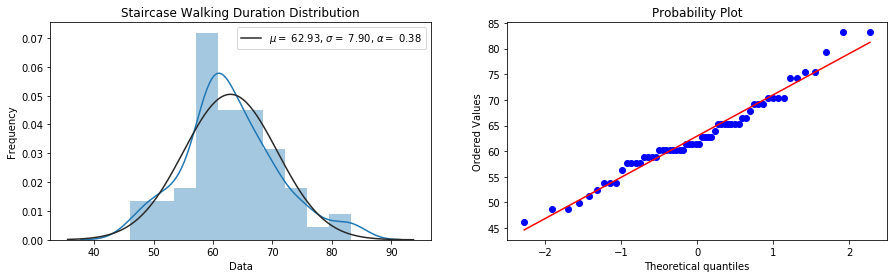

In [16]:
def plotSkew(x):
    # Fit label to norm
    (mu, sigma) = norm.fit(x)
    alpha = skew(x)

    fig, axarr = plt.subplots(1, 2, figsize=(15,4))

    # Plot label and fit
    sns.distplot(x , fit=norm, ax=axarr[0])
    axarr[0].legend(['$\mu=$ {:.2f}, $\sigma=$ {:.2f}, $\\alpha=$ {:.2f}'.format(mu, sigma, alpha)], loc='best')
    axarr[0].set_title('Staircase Walking Duration Distribution')
    axarr[0].set_ylabel('Frequency')

    # Plot probability plot
    res = probplot(x, plot=axarr[1])
    plt.show()
    
    
plotSkew(duration_df)

As aspected from most real world data the duration walking on the staircase is **normally distributed**

### <a id=5.7>Is There A Unique Walking Style For Each Participant?</a>

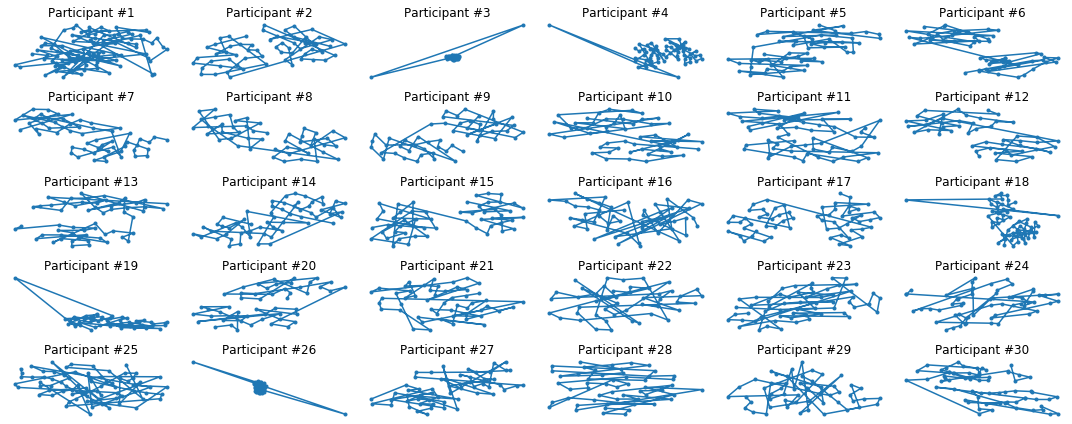

In [17]:
fig, axarr = plt.subplots(5, 6, figsize=(15,6))

for person in range(0, 30):
    # Get data
    single_person = both_df[(label=='WALKING') & (both_df['subject']=='#{}'.format(person+1))].drop(['subject', 'Data'], axis=1)
    # Scale data
    scl = StandardScaler()
    tsne_data = scl.fit_transform(single_person)
    # Reduce dimensions
    pca = PCA(n_components=0.9, random_state=3)
    tsne_data = pca.fit_transform(tsne_data)
    # Transform data
    tsne = TSNE(random_state=3)
    tsne_transformed = tsne.fit_transform(tsne_data)
    
    # Create plot
    axarr[person//6][person%6].plot(tsne_transformed[:,0], tsne_transformed[:,1], '.-')
    axarr[person//6][person%6].set_title('Participant #{}'.format(person+1))
    axarr[person//6][person%6].axis('off')
    
plt.tight_layout()
plt.show()

For this visualisation i am assuming the **datapoints were not shuffled** and are in the correct order (time series).

Visualising the walking structure for each participant you can see some **outliers** (e. g. #4,  #18 and #26) in the data, which **could be 'starting to walk', 'stopping' or 'stumble'.** Additional there are **two clusters for each participant.** How these clusters should be interpreted is not clear.<br>
It cannot be the steps for each foot, since there would be connections between the clusters for each alternating step. Due to the fact that there is (mostly) only a single connection between the clusters and each cluster has just about the same size I conclude **each cluster represents a single walking experiment.**

### <a id=5.8>How Long Does The Participant Walk?</a>

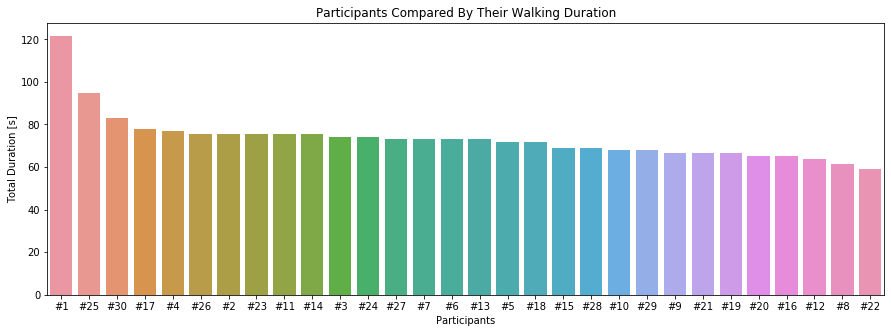

In [18]:
# Group the data by participant and compute total duration of walking
mask = label=='WALKING'
duration_df = (both_df[mask].groupby('subject')['Data'].count() * 1.28)

# Create plot
plot_data = duration_df.reset_index().sort_values('Data', ascending=False)

plt.figure(figsize=(15,5))
sns.barplot(data=plot_data, x='subject', y='Data')
plt.title('Participants Compared By Their Walking Duration')
plt.xlabel('Participants')
plt.ylabel('Total Duration [s]')
plt.show()

Since the duration of each participant walking is distributed over a range I assume the participants had a **fixed walking distance for their experiment** rather than a fixed duration.

### <a id=5.9>Is There A Unique Staircase Walking Style For Each Participant?</a>

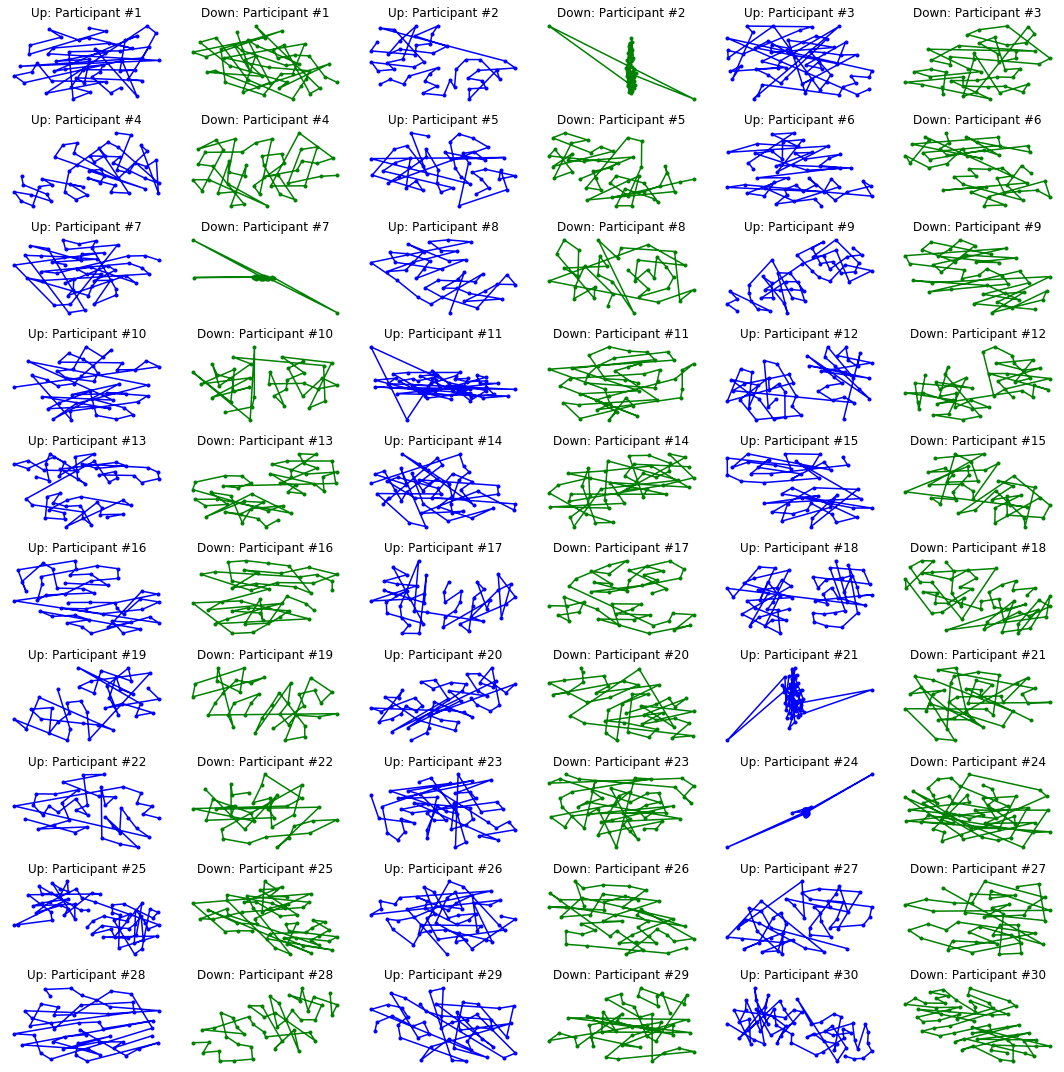

In [19]:
# Create subplots
fig, axarr = plt.subplots(10, 6, figsize=(15,15))

# Iterate over each participant
for person in range(0, 30):
    # Get data
    single_person_up = both_df[(label=='WALKING_UPSTAIRS') & (both_df['subject']=='#{}'.format(person+1))].drop(['subject', 'Data'], axis=1)
    single_person_down = both_df[(label=='WALKING_DOWNSTAIRS') & (both_df['subject']=='#{}'.format(person+1))].drop(['subject', 'Data'], axis=1)
    # Scale data
    scl = StandardScaler()
    tsne_data_up = scl.fit_transform(single_person_up)
    tsne_data_down = scl.fit_transform(single_person_down)
    # Reduce dimensions
    pca = PCA(n_components=0.9, random_state=3)
    tsne_data_up = pca.fit_transform(tsne_data_up)
    tsne_data_down = pca.fit_transform(tsne_data_down)
    # Transform data
    tsne = TSNE(random_state=3)
    tsne_transformed_up = tsne.fit_transform(tsne_data_up)
    tsne_transformed_down = tsne.fit_transform(tsne_data_down)
    
    # Create plot
    axarr[2*person//6][2*person%6].plot(tsne_transformed_up[:,0], tsne_transformed_up[:,1], '.b-')
    axarr[2*person//6][2*person%6].set_title('Up: Participant #{}'.format(person+1))
    axarr[2*person//6][2*person%6].axis('off')
    axarr[2*person//6][(2*person%6)+1].plot(tsne_transformed_down[:,0], tsne_transformed_down[:,1], '.g-')
    axarr[2*person//6][(2*person%6)+1].set_title('Down: Participant #{}'.format(person+1))
    axarr[2*person//6][(2*person%6)+1].axis('off')
    
plt.tight_layout()
plt.show()

## <a id=7>Conclusion</a>

Within a short time **(1-1.5 min)** the smartphone has enough data to determine what its user is doing (**95%**: 6 activities) or who the user is (**Walking 94%**: 30 participants) and even the basics of a persons specific walking style (**Slow steps per second**). By linking this insights to more personal data of the participants extensiv options open up.<br>
In addition this insights have been extracted from only two smartphone sensors which probably could be accessed by most of our Apps.<br>
**Let us not consider for how long we have been carrying our gadgets around.**

I hope this was interesting for you.<br>
Have a good day.